In [1]:
from mylib.statistic_test import *

code_id = '0352 - Cross-Day Decoding'
loc = os.path.join(figpath, code_id)
mkdir(loc)

decoded_data_saved = False
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0352 - Cross-Day Decoding is already existed!


In [2]:
def decode_data(
    i: int,
    fs: pd.DataFrame = f_CellReg_modi,
    dirs: str = None,
    is_shuffle: bool = False,
    n_neurons: int = 100
):    
    if i >= 14 and dirs is None:
        raise ValueError("Please provide the directory for HairpinMaze or ReverseMaze.")
        
    cellreg_dir = fs['cellreg_folder'][i]
    mouse = int(fs['MiceID'][i])
    stage = fs['Stage'][i]
    session = int(fs['session'][i])
    maze_type = int(fs['maze_type'][i])
    paradigm = fs['paradigm'][i]

    index_map = GetMultidayIndexmap(
        mouse,
        stage=stage,
        session=session,
        i = i,
        occu_num=2,
        f=fs
    )
    index_map[np.where((np.isnan(index_map))|(index_map < 0))] = 0
    
    if paradigm == 'CrossMaze':
        fdata = f1
    elif paradigm == 'ReverseMaze':
        fdata = f3
    elif paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]
        
    traces = []
    for idx in tqdm(file_indices):
        with open(fdata['Trace File'][idx], 'rb') as handle:
            trace = pickle.load(handle)
            traces.append(trace)
            
    print(f"{mouse}, {paradigm}, {dirs} {'' if is_shuffle == False else 'Shuffle'} -------------------------------")
    D = GetDMatrices(maze_type, 48)
    losses = np.zeros((len(file_indices), len(file_indices))) * np.nan
    nn = np.zeros((len(file_indices), len(file_indices)), dtype=np.int64)
    for j in tqdm(range(len(file_indices)-1, 0, -1)):
        for i in range(j-1, max(-1, j-11), -1):
            print(f"    S{i} -> S{j}    ")
            cell_idx = np.where(
                (index_map[i, :] > 0) & (index_map[j, :] > 0)
            )[0]

            if cell_idx.shape[0] < n_neurons:
                print(f"LimitedNeuronWarning: {mouse} {paradigm} {dirs} pair (S{i}, S{j}): {n_neurons}")
                n_neurons = cell_idx.shape[0]

            if paradigm == 'CrossMaze':
                X_train = traces[i]['RawTraces']
                X_train = SpikeType(X_train, 3)
                Y_train = traces[i]['spike_nodes_original']
                idx = np.where(np.isnan(Y_train) == False)[0]
                X_train = X_train[:, idx].astype(np.int64)
                Y_train = Y_train[idx].astype(np.int64)

                X_test = traces[j]['RawTraces']
                X_test = SpikeType(X_test, 3)
                Y_test = traces[j]['spike_nodes_original']
                idx = np.where(np.isnan(Y_test) == False)[0]
                X_test = X_test[:, idx].astype(np.int64)
                Y_test = Y_test[idx].astype(np.int64)

                Ms = traces[i]['Ms']
            else:
                raw_traces = traces[i]['RawTraces']
                X_train = SpikeType(raw_traces, 3)
                raw_time = traces[i]['ms_time']
                X_train_time = traces[i][f'{dirs}']['ms_time_behav']
                X_train = X_train[:, np.isin(raw_time, X_train_time)]
                Y_train = traces[i][f'{dirs}']['spike_nodes']
                
                raw_traces = traces[j]['RawTraces']
                X_test = SpikeType(raw_traces, 3)
                raw_time = traces[j]['ms_time']
                X_test_time = traces[j][f'{dirs}']['ms_time_behav']
                X_test = X_test[:, np.isin(X_test_time, raw_time)]
                Y_test = traces[j][f'{dirs}']['spike_nodes']
                Ms = traces[i]['Ms']

            print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

            loss = np.zeros(5) if cell_idx.shape[0] >= n_neurons + 1 else np.zeros(1)
            for n in range(loss.shape[0]):
                print(f"      Iter {n}:  ", end="")
                downsample_idx = np.random.choice(cell_idx, size=n_neurons, replace=False)
                model = NaiveBayesDecoder(maze_type=maze_type, res=48, smooth_matrix=Ms)
                model.fit(X_train[index_map[i, downsample_idx]-1, :], Y_train)
                
                if is_shuffle:
                    rand_idx = np.random.choice(np.arange(X_test.shape[0]), size=n_neurons, replace=False)
                    X_test_dow = X_test[rand_idx, :]
                else:
                    X_test_dow = X_test[index_map[j, downsample_idx]-1, :]

                Y_pred = model.predict(X_test_dow, Y_test)
                loss[n] = np.nanmedian(D[(Y_pred.astype(np.int64)-1, Y_test.astype(np.int64)-1)])
                print(f"{loss[n]} cm")
            losses[i, j] = np.nanmean(loss)
            nn[i, j] = n_neurons
    
    if paradigm == 'CrossMaze':
        paradm = 'MA' if maze_type == 1 else 'MB'
    elif paradigm == 'ReverseMaze':
        paradm = 'MAf' if dirs == 'cis' else 'MAb'
    elif paradigm == 'HairpinMaze':
        paradm = 'HPf' if dirs == 'cis' else 'HPb'
        
    postfix = '_shuf' if is_shuffle else ''

    with open(join(loc, f"{mouse}_{paradm}{postfix}.pkl"), 'wb') as handle:
        pickle.dump((losses, nn), handle)
        

for i in range(8):
    if f_CellReg_modi['Type'][i] != 'Real':
        continue
    """
    if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
        decode_data(i, fs=f_CellReg_modi, is_shuffle=False, n_neurons=100)
        decode_data(i, fs=f_CellReg_modi, is_shuffle=True, n_neurons=100)
    else:
        decode_data(i, fs=f_CellReg_modi, dirs='cis', is_shuffle=False, n_neurons=100)
        decode_data(i, fs=f_CellReg_modi, dirs='cis', is_shuffle=True, n_neurons=100)
        decode_data(i, fs=f_CellReg_modi, dirs='trs', is_shuffle=False, n_neurons=100)
        decode_data(i, fs=f_CellReg_modi, dirs='trs', is_shuffle=True, n_neurons=100)
    """

6it [00:00, 1745.69it/s]
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_23328\4273413111.py:107: RuntimeWarning: Mean of empty slice
  Loss3D[k] = np.nanmean(Loss3D[k], axis=2)


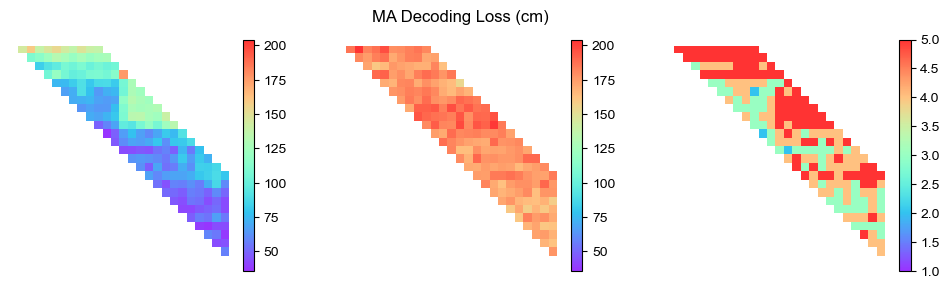

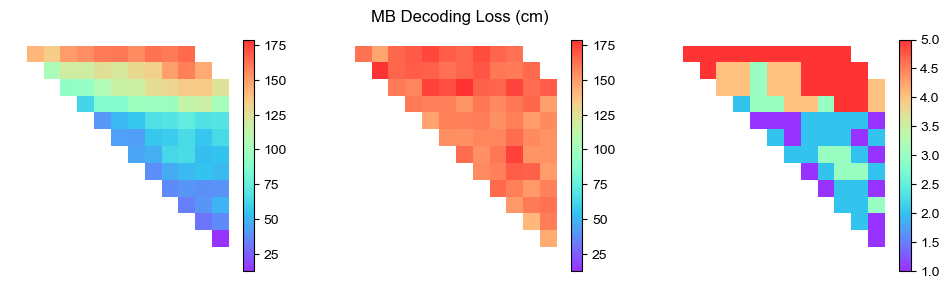

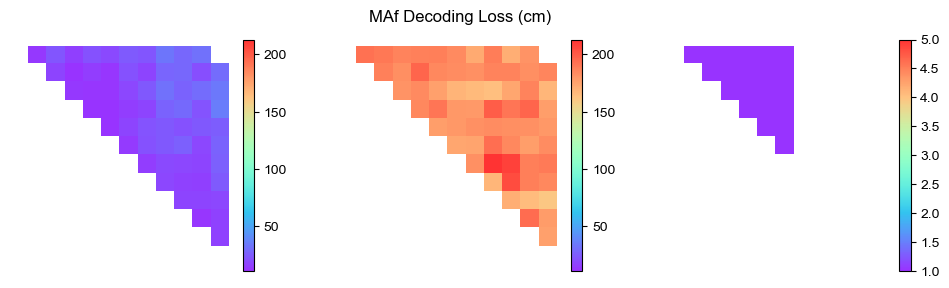

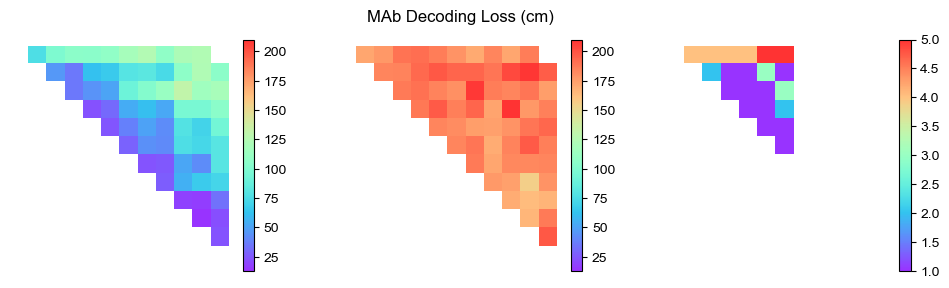

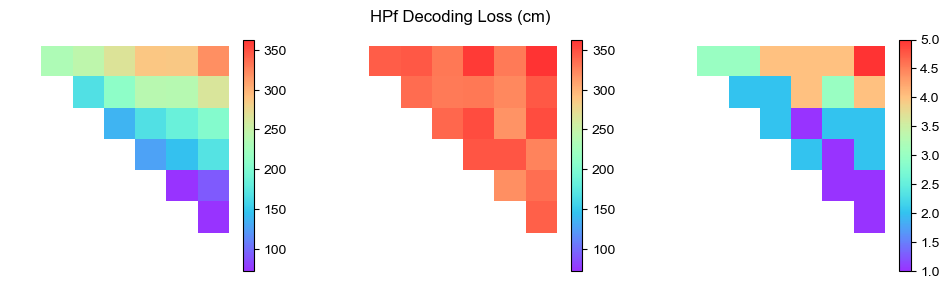

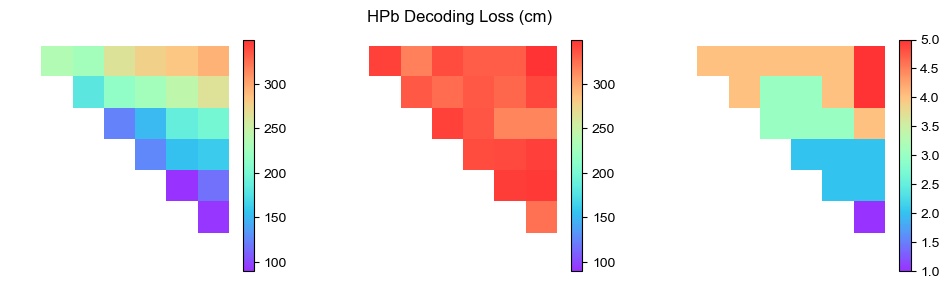

In [13]:
if exists(join(figdata, f"{code_id}.pkl")) == False:
    LossData = {
        "MiceID": [],
        "Paradigm": [],
        "Type": [], # Shuffle or Real Data,
        "Loss": [],
        "Training Session": [],
        "Testing Session": [],
        "N Neurons": []
    }
    
    for mouse in tqdm([10209, 10212, 10224, 10227, 10232, 10234]):
        if mouse in [10232, 10234]:
            paradigms = ['MA', 'MB']
        else:
            paradigms = ['MA', 'MB', 'MAf', 'MAb', 'HPf', 'HPb']
        
        for paradm in paradigms:
            for is_shuffle in [False, True]:
                postfix = '_shuf' if is_shuffle else ''
                try:
                    with open(join(loc, f"{mouse}_{paradm}{postfix}.pkl"), 'rb') as handle:
                        losses, nn = pickle.load(handle)
                except:
                    print(f"File {mouse}_{paradm}{postfix}.pkl not found.")
                    continue
                
                for i in range(losses.shape[0]):
                    for j in range(losses.shape[1]):
                        if np.isnan(losses[i, j]):
                            continue
                        LossData['MiceID'].append(mouse)
                        LossData['Paradigm'].append(paradm)
                        LossData['Type'].append('Shuffle' if is_shuffle else 'Real')
                        LossData['Loss'].append(losses[i, j])
                        LossData['Training Session'].append(i)
                        LossData['Testing Session'].append(j)
                        LossData['N Neurons'].append(nn[i, j])
                        
    for k in LossData.keys():
        LossData[k] = np.array(LossData[k])
        
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as handle:
        pickle.dump(LossData, handle)
        
    LossD = pd.DataFrame(LossData)
    LossD.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    print(len(LossD))
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        LossData = pickle.load(handle)
LossData['Session Interval'] = LossData['Testing Session'] - LossData['Training Session']

if exists(join(figdata, f" {code_id} [3D].pkl")) == False:
    Loss3D = {
        # Axis 0 and 1: Training and Testing Session, 
        # Axis 2 for mouse, Axis 3: Real (0) or Shuffle (1)
        "MA": np.zeros((26, 26, 6, 2)) * np.nan, 
        "MB": np.zeros((13, 13, 6, 2)) * np.nan,
        "MAf": np.zeros((12, 12, 6, 2)) * np.nan,
        "MAb": np.zeros((12, 12, 6, 2)) * np.nan,
        "HPf": np.zeros((7, 7, 6, 2)) * np.nan,
        "HPb": np.zeros((7, 7, 6, 2)) * np.nan,
    }
    for m, mouse in tqdm(enumerate([10209, 10212, 10224, 10227, 10232, 10234])):
        if mouse in [10232, 10234]:
            paradigms = ['MA', 'MB']
        else:
            paradigms = ['MA', 'MB', 'MAf', 'MAb', 'HPf', 'HPb']
        
        for paradm in paradigms:
            for is_shuffle in [False, True]:
                postfix = '_shuf' if is_shuffle else ''
                try:
                    with open(join(loc, f"{mouse}_{paradm}{postfix}.pkl"), 'rb') as handle:
                        losses, nn = pickle.load(handle)
                except:
                    print(f"File {mouse}_{paradm}{postfix}.pkl not found.")
                    continue
                
                L = losses.shape[0]
                Loss3D[paradm][:L, :L, m, 1 if is_shuffle else 0] = losses
    
    Loss3DPvalue = {
        "MA": np.zeros((26, 26)) * np.nan, 
        "MB": np.zeros((13, 13)) * np.nan,
        "MAf": np.zeros((12, 12)) * np.nan,
        "MAb": np.zeros((12, 12)) * np.nan,
        "HPf": np.zeros((7, 7)) * np.nan,
        "HPb": np.zeros((7, 7)) * np.nan,
    }
    
    for k in Loss3D.keys():
        for m in range(Loss3D[k].shape[0]-1):
            for n in range(m+1, Loss3D[k].shape[1]):
                idx = np.where(
                    (np.isnan(Loss3D[k][m, n, :, 0]) == False) & 
                    (np.isnan(Loss3D[k][m, n, :, 1]) == False)
                )[0]
                if len(idx) < 3:
                    continue
                real_data = Loss3D[k][m, n, :, 0]
                shuffle_data = Loss3D[k][m, n, :, 1]
                
                Loss3DPvalue[k][m, n] = ttest_ind(real_data[idx], shuffle_data[idx]).pvalue
                
        Loss3D[k] = np.nanmean(Loss3D[k], axis=2)
    
    with open(join(figdata, f"{code_id} [3D].pkl"), 'wb') as handle:
        pickle.dump([Loss3D, Loss3DPvalue], handle)
else:
    with open(join(figdata, f"{code_id} [3D].pkl"), 'rb') as handle:
        Loss3D, Loss3DPvalue = pickle.load(handle)


ticks = np.linspace(10, 300, 30)
labels = np.linspace(10, 300, 30).astype(np.int64)
for paradm in Loss3D.keys():
    L = Loss3D[paradm].shape[0]
    M = Loss3D[paradm]
    vmin, vmax = np.nanmin((Loss3D[paradm])), np.nanmax((Loss3D[paradm]))
    idx = np.where((ticks >= vmin) & (ticks <= vmax))[0]
    if min(idx) > 0:
        idx = np.concatenate([[min(idx)-1], idx])
    if max(idx) < len(ticks)-1:
        idx = np.concatenate([idx, [max(idx)+1]])
        
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))
    ax0, ax1, ax2 = Clear_Axes(axes[0]), Clear_Axes(axes[1]), Clear_Axes(axes[2])
    im0 = ax0.imshow(
        M[:, :, 0], 
        cmap='rainbow', 
        vmin=vmin, vmax=vmax,
        alpha=0.8
    )
    cbar0 = fig.colorbar(im0, ax=ax0)
    im1 = ax1.imshow(
        Loss3D[paradm][:, :, 1], 
        cmap='rainbow', 
        vmin=vmin, vmax=vmax,
        alpha=0.8
    )
    cbar1 = fig.colorbar(im1, ax=ax1)
    nan_mask = np.isnan(Loss3DPvalue[paradm])
    Loss3DPvalue[paradm][nan_mask] = 1.1
    mat = np.digitize(Loss3DPvalue[paradm], bins=[0, 0.0001, 0.001, 0.01, 0.05, 1]).astype(np.float64)
    mat[nan_mask] = np.nan
    im2 = ax2.imshow(
        mat,
        cmap='rainbow',
        alpha=0.8,
        vmin=1, vmax=5
    )
    cbar2 = fig.colorbar(im2, ax=ax2)
    plt.suptitle(f"{paradm} Decoding Loss (cm)")
    plt.savefig(join(loc, f"Loss {paradm}.png"), dpi=600)
    plt.savefig(join(loc, f"Loss {paradm}.svg"))
    plt.show()
    
    